In [3]:
import tensorflow as tf
print ("TensorFlow version: " + tf.__version__)

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
plt.switch_backend('agg')
from tensorflow.keras import backend as K
# from tensorflow.keras.engine.topology import Layer, InputSpec
from tensorflow.keras import initializers
%matplotlib inline


# import data processing and other libraries
import csv
import sys
import requests
import os
import re
import pprint
import pymongo
import traceback
from time import sleep
import requests
import pandas as pd
import io
from IPython.display import display
import time
import numpy as np
from bs4 import BeautifulSoup
import string
import random
from urllib.parse import urlparse, urljoin
from collections import defaultdict
from collections import OrderedDict
import collections
import pickle
from collections import defaultdict

from boilerpipe.extract import Extractor

import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

TensorFlow version: 1.12.0


In [17]:
import warnings;
warnings.simplefilter('ignore')

In [5]:
# For a single-input model with 2 classes (binary classification):

model = tf.keras.Sequential()
model.add(Dense(32, activation='relu', input_dim=100))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Generate dummy data
import numpy as np
data = np.random.random((1000, 100))
labels = np.random.randint(2, size=(1000, 1))

# Train the model, iterating on the data in batches of 32 samples
model.fit(data, labels, epochs=10, batch_size=32)

Epoch 1/10
1000/1000 [==============================] - 0s 157us/step - loss: 0.7242 - acc: 0.4920
Epoch 2/10
1000/1000 [==============================] - 0s 26us/step - loss: 0.7049 - acc: 0.5050
Epoch 3/10
1000/1000 [==============================] - 0s 26us/step - loss: 0.6950 - acc: 0.5250
Epoch 4/10
1000/1000 [==============================] - 0s 27us/step - loss: 0.6884 - acc: 0.5510
Epoch 5/10
1000/1000 [==============================] - 0s 26us/step - loss: 0.6855 - acc: 0.5400
Epoch 6/10
1000/1000 [==============================] - 0s 26us/step - loss: 0.6781 - acc: 0.5640
Epoch 7/10
1000/1000 [==============================] - 0s 27us/step - loss: 0.6741 - acc: 0.5790
Epoch 8/10
1000/1000 [==============================] - 0s 26us/step - loss: 0.6699 - acc: 0.5940
Epoch 9/10
1000/1000 [==============================] - 0s 26us/step - loss: 0.6676 - acc: 0.5980
Epoch 10/10
1000/1000 [==============================] - 0s 26us/step - loss: 0.6668 - acc: 0.5950


## Load labeled data

In [30]:
MONGODB_DB = "FirmDB"
MONGODB_COLLECTION = "pages_ABOUT2"
CONNECTION_STRING = "mongodb://localhost"
username = "scrapy"
password = "eager"
authSource = "FirmDB"
authMechanism='SCRAM-SHA-1'

client = pymongo.MongoClient(CONNECTION_STRING, username=username, password=password, authSource=authSource, authMechanism=authMechanism)
db = client[MONGODB_DB]
col = db[MONGODB_COLLECTION]

ABOUT_DIR = '../../data/orgs/about/'
DATA_DIR = '../../data/orgs/parsed_page_output/'
GLOVE_DIR = '/home/ubuntu/glove/'

TRAINING_PERCENT = .10
PHRASE_LENGTH = 60
MIN_PARA_LEN = 5
pp = pprint.PrettyPrinter()

In [12]:
def get_domain (url):
    o = urlparse(url.lower())
    domain = o.netloc.strip('www.')
    return domain

# output urls for labeling of training data
results = col.find({},{"url": 1, "firm_name": 1})
df = pd.DataFrame(columns = ('firm_name', 'url', 'label'))
domain_count = defaultdict(lambda:0,{})
for i in range(results.count()):
    result = results.next()
    url = result['url'][0]
    domain_count[get_domain(url)] += 1
    firm_name = result['firm_name'][0] if 'firm_name' in result else ''
    df.loc[i] = [firm_name, url, '']

firm_names = list(set(df['firm_name']))
df['gid'] = df.groupby(['firm_name']).ngroup()

/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  # Remove the CWD from sys.path while we load stuff.


In [13]:
# read back labeled data (note that about, management/team and partners, are dichotomous)
df_about_labeled = pd.read_csv(ABOUT_DIR + 'about_pages_labeled_v3.csv')
df_about_labeled = df_about_labeled.fillna(0)

# count pages per domain
for index, row in df_about_labeled.iterrows():
    pages_in_domain = domain_count[get_domain(row['url'])]
    df_about_labeled.loc[index,'pages_in_domain'] = pages_in_domain
    is_sole_page = 0 if pages_in_domain > 1 else 1
    df_about_labeled.loc[index,'is_sole_page'] = is_sole_page
    
labeled_urls = list(df_about_labeled['url']) # for training models on labeled urls below = 
about_labels = list(df_about_labeled['about_lbl'])
mgmt_labels = list(df_about_labeled['mgmt_lbl'])
partner_labels = list(df_about_labeled['partners_lbl'])
ip_labels = list(df_about_labeled['ip_lbl'])
df_about_labeled = df_about_labeled.set_index(['firm_name', 'url'])
print (df_about_labeled.columns.tolist())

# final test set is the rows of the original data frame without the urls in df_about_labeled 

['about_lbl', 'mgmt_lbl', 'partners_lbl', 'ip_lbl', 'about_agg_lbl', 'gid', 'pages_in_domain', 'is_sole_page']


In [14]:
print(labeled_urls[:10])
print(about_labels[:10])
print(mgmt_labels[:10])
print(partner_labels[:10])
print(ip_labels[:10])
df_about_labeled.head(10)

['https://www.3m.com/', 'https://www.3m.com/3M/en_US/company-us/site-map/', 'https://www.3m.com/3M/en_US/company-us/about-3m/', 'https://www.3m.com/3M/en_US/home-improvement-us/', 'https://www.3m.com/3M/en_US/company-us/SDS-search/', 'https://www.3m.com/3M/en_US/company-us/patent/', 'https://www.3m.com/3M/en_US/company-us/help-center/', 'http://acaciaresearch.com/corporate-governance/', 'http://acaciaresearch.com/history/', 'http://acaciaresearch.com/corporate-profile/']
[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]


about_lbl  \
firm_name                        url                                                             
3M Innovative Properties Company https://www.3m.com/                                       0.0   
                                 https://www.3m.com/3M/en_US/company-us/site-map/          0.0   
                                 https://www.3m.com/3M/en_US/company-us/about-3m/          1.0   
                                 https://www.3m.com/3M/en_US/home-improvement-us/          0.0   
                                 https://www.3m.com/3M/en_US/company-us/SDS-search/        0.0   
                                 https://www.3m.com/3M/en_US/company-us/patent/            0.0   
                                 https://www.3m.com/3M/en_US/company-us/help-cen...        0.0   
ACACIA RESEARCH GROUP LLC        http://acaciaresearch.com/corporate-governance/           0.0   
                                 http://acaciaresearch.com/history/                        0.0   
                                 http://acaciaresearch.com/corporate-profile/              1.0   

                                                                                     mgmt_lbl  \
firm_name                        url                                                            
3M Innovative Properties Company https://www.3m.com/                                      0.0   
                                 https://www.3m.com/3M/en_US/company-us/site-map/         0.0   
                                 https://www.3m.com/3M/en_US/company-us/about-3m/         0.0   
                                 https://www.3m.com/3M/en_US/home-improvement-us/         0.0   
                                 https://www.3m.com/3M/en_US/company-us/SDS-search/       0.0   
                                 https://www.3m.com/3M/en_US/company-us/patent/           0.0   
                                 https://www.3m.com/3M/en_US/company-us/help-cen...       0.0   
ACACIA RESEARCH GROUP LLC        http://acaciaresearch.com/corporate-governance/          1.0   
                                 http://acaciaresearch.com/history/                       0.0   
                                 http://acaciaresearch.com/corporate-profile/             0.0   

                                                                                     partners_lbl  \
firm_name                        url                                                                
3M Innovative Properties Company https://www.3m.com/                                          0.0   
                                 https://www.3m.com/3M/en_US/company-us/site-map/             0.0   
                                 https://www.3m.com/3M/en_US/company-us/about-3m/             0.0   
                                 https://www.3m.com/3M/en_US/home-improvement-us/             0.0   
                                 https://www.3m.com/3M/en_US/company-us/SDS-search/           0.0   
                                 https://www.3m.com/3M/en_US/company-us/patent/               0.0   
                                 https://www.3m.com/3M/en_US/company-us/help-cen...           0.0   
ACACIA RESEARCH GROUP LLC        http://acaciaresearch.com/corporate-governance/              0.0   
                                 http://acaciaresearch.com/history/                           0.0   
                                 http://acaciaresearch.com/corporate-profile/                 0.0   

                                                                                     ip_lbl  \
firm_name                        url                                                          
3M Innovative Properties Company https://www.3m.com/                                    0.0   
                                 https://www.3m.com/3M/en_US/company-us/site-map/       0.0   
                                 https://www.3m.com/3M/en_US/company-us/about-3m/       0.0   
                                 https://www.3m.com/3M/

## Load full document features

### Code from extract-pages-from-mongo

In [15]:
def strip_firm_name (firm_name, text):
    strip_regex = re.compile(r"(" + "\s|".join(firm_name.split()) + "\s)", re.IGNORECASE)
    clnd_text = strip_regex.sub ('', text)
    
    more_regex = re.compile(r"([A-Z]\.?){1,} ")
    clnd_text = more_regex.sub ('', clnd_text)
    
    return ' '.join(clnd_text.split(' '))

# standard firm cleaning regex
def clean_firm_name (firm):
    firm_clnd = re.sub('(\.|,| corporation| incorporated| llc| inc| international| gmbh| ltd)', '', firm, flags=re.IGNORECASE).rstrip()
    return firm_clnd

# remove html content
def is_javascript (x):
    match_string = r"(CDATA|return\s+true|return\s+false|getelementbyid|function|\w+\(.*?\);|\w{2,}[\\.|:]+\w{2,}|header|hover|'\w+':\s+'\w+|\\|{|}|\r|\n|\/\/')"
    # capture CDATA; function declarations; function calls; word sequences separated by a period (e.g., denoting paths)
    regex = re.findall(match_string, x) 
    # check to see if the regex finds some percentage of the words look like javascript patterns
    if (len(regex) / float(len(x.split())) > .10):
        return True 
    else:
        return False

def clean_page_content (text_list):
    # remove whatever we think is html
    removed_html = filter(lambda x: not( bool(BeautifulSoup(x, "html.parser").find()) ), text_list)
    # remove content that looks like javascript 
    removed_js = filter(lambda x: not (is_javascript(x)), removed_html)
    # add other checks here as needed

    return removed_js
    
# iterate through firm urls and return concatenated string
def get_content (firm_name, urls): 
    url_to_text_dict = {}
    for url in urls:
        running_text = ''
        # print ('\tWorking on ' + url)
        result = col.find_one( {"url": url} )
        if result:
            clnd_text = clean_page_content(result['full_text'])
            clnd_text = '\n'.join(clnd_text)
            boilerpipe = None
            
            if 'body' in result:
                extractor = Extractor(extractor='DefaultExtractor', html = result['body'][0])
                lines = extractor.getText().replace(u'\xa0', u' ').split('\n')
                filtered = filter(lambda x: not re.match(r'^\s*$', x), lines)
                boilerpipe = '\n'.join(filtered)

            # TODO fix to split().  Counting characters currently 
            if boilerpipe and (len(boilerpipe) > .5 * len(clnd_text)):
                # print ('\t\tUsing boilerplate')
                running_text += boilerpipe
            else:
                # print ('\t\tUsing clnd_text')
                running_text += clnd_text
            
            running_text_clnd = strip_firm_name (firm_name, running_text)
            url_to_text_dict[url] = running_text.split('\n')
        else:
            print ('Cannot find url: ' + url)

    return url_to_text_dict

In [18]:
# run process_firm and write to file
pp = pprint.PrettyPrinter()

url_to_text_dict = {}
for firm_name in firm_names: 
    # print ("Working on " + firm_name)
    results = col.find ({'firm_name': firm_name})
    if not results:
        print ("\tCouldn't find any urls for firm!")
        continue
    
    urls = []
    for result in results: 
        urls.append (result['url'][0])
    
    # pp.pprint (urls) 
    # print (len(urls))
    return_dict = get_content (firm_name, urls)
    url_to_text_dict = {**url_to_text_dict, **return_dict}

In [19]:
pp.pprint (url_to_text_dict['http://2blades.org/our-team/'])

['Skip to main content',
 '2Blades Foundation',
 'The Unmet Need',
 'How We Work',
 'Our Team',
 'Overview',
 'Management & Directors',
 '2Blades Group, The Sainsbury Laboratory',
 'Scientific Advisory Board',
 '2Blades Groups',
 'Overview',
 'Norwich, UK',
 'Projects & Technology',
 'Current Projects',
 'Technology Patent Estate and Development',
 'Project Grants',
 'Potential Future Projects',
 'News & Media',
 'News',
 'In the News',
 'Newsletters',
 'Infographics',
 'Videos',
 'Management & Directors',
 'Dr. Roger Freedman',
 'Chairman',
 '2Blades Projects',
 'Wheat Stem Rust',
 'Dr. Roger Freedman works for David Sainsbury, the settlor of the Gatsby '
 'Foundation and until recently the UK Minister of Science and Innovation. Dr. '
 'Freedman established the Gatsby Foundation’s programs in plant science and '
 'neuroscience and continues to serve the Foundation’s much expanded plant '
 'science program. He has been a member of the governing council of the '
 'Sainsbury Laboratory i

### Code from topic-model

In [21]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [22]:
# pattern regex to remove unwanted words that show up in topic models
p = re.compile(r"(\(\)|''|``|\"|null|ul|li|ol|^\.|^:|^/|\\|--|cooki|'s|corpor|busi|inc\.|ltd|co\.|compan|keyboard|product|technolog)", flags=re.IGNORECASE)

def encode_item(text):
    '''
    Remove characters with encoding problems 
    '''
    clean = ""
    for item in text.split(" "):
        try:
            clean += item.encode('ascii','ignore').decode('utf-8') + " "
        except: 
            pass
    return clean.rstrip()

stopwords = nltk.corpus.stopwords.words('english') + list(set(string.punctuation))
stemmer = SnowballStemmer("english")

#tokenize text for topic modelling
def stem_tokenizer(text):
    '''
    Tokenize and stem an input sentence"
    '''
    words_stemmed = list(filter(lambda x : not x in stopwords, [stemmer.stem(word) for word in nltk.word_tokenize(text)]))
    return words_stemmed

def clean_text (text):
    clnd_text = list(filter(lambda x : not p.match(x), text))
    return clnd_text

def return_for_model(text):
    '''
    Deal with endcoding and return stemmed/tokenized text
    '''
    all_content = [encode_item(item) for item in text] 
    all_content_stem_token = list(map(stem_tokenizer, all_content))
    all_content_clnd = list(map(clean_text, all_content_stem_token))
    all_content_trimmed = [c for c in all_content_clnd if len(c) >= MIN_PARA_LEN ]
    
    all_content_no_dups = []
    seen = {}
    for trimmed in all_content_trimmed:
        trimmed_joined = '|'.join(trimmed)
        if trimmed_joined not in seen: 
            all_content_no_dups.append(trimmed)
            seen[trimmed_joined] = 1
        
    return all_content_no_dups

def process_doc (document):
    # loop over text and add title elements to the paragraph they describe
    joined = []
    buf = ''
    for i in range(len(document)): # figure out a way to chunk groups of content
        if re.search (r'cookie|privacy|terms|GDPR', document[i], re.IGNORECASE):
            continue
        if len(document[i]) <= 12 or len(document[i].split()) < MIN_PARA_LEN : # maybe a menu or simple pagragraph heading? 
            continue
        if re.search(r'(\.|;|\!)', document[i]): # found what appears to be a sentence
            if buf:
                joined.append(buf.strip())
                buf = ''
            joined.append(document[i].strip())
        elif len(buf) > PHRASE_LENGTH: # the rest of this code processes free-standing text 
            joined.append(buf.strip())
            buf = document[i]
        else: 
            buf = buf + ' ' + document[i]
    if buf:
        joined.append(buf.rstrip())

    # pp.pprint (joined)
    return ' '.join (joined)

In [23]:
labeled_texts = []
unlabeled_texts = []

for url, text in url_to_text_dict.items():
    # print (url)
    # pp.pprint (text)

    for k in ["\n", "\t", " "]: # remove the end of sentence tags
        text = [item.strip(k) for item in text]
    text = list(filter(lambda x : not x in [' ', '', '\t'],text)) #remove the paragraphs that are just blank space
    processed_text = process_doc (text)
    
    if url in labeled_urls:
        labeled_texts.append(processed_text)
    else:
        unlabeled_texts.append(processed_text)

In [25]:
# pp.pprint (texts)
print (len(labeled_urls))
print (len(about_labels))
print (len(labeled_texts))
print (len(unlabeled_texts))

1004
1004
1004
8658


## Recurrent LSTM neural net
Code modified from https://medium.com/jatana/report-on-text-classification-using-cnn-rnn-han-f0e887214d5f

In [26]:
MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

In [27]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(labeled_texts)
sequences = tokenizer.texts_to_sequences(labeled_texts)

word_index = tokenizer.word_index

print('Number of Unique Tokens',len(word_index))

Number of Unique Tokens 27306


In [28]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = np.array(about_labels)

print('Shape of Data Tensor:', data.shape)
print('Shape of Label Tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
print (indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

Shape of Data Tensor: (1004, 1000)
Shape of Label Tensor: (1004,)
[605 156 853 ... 137 671 219]
(804, 1000)
(804,)
(200, 1000)
(200,)


In [31]:
embeddings_index = {}
f = open(GLOVE_DIR + 'glove.6B.100d.txt',encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove 6B 100d.' % len(embeddings_index))

Total 400000 word vectors in Glove 6B 100d.


In [32]:
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [33]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

In [34]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_lstm = Bidirectional(LSTM(100))(embedded_sequences)
preds = Dense(1, activation='softmax')(l_lstm)
model = Model(sequence_input, preds)
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

print("Bidirectional LSTM")
model.summary()

Bidirectional LSTM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding (Embedding)        (None, 1000, 100)         2730700   
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               160800    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 201       
Total params: 2,891,701
Trainable params: 2,891,701
Non-trainable params: 0
_________________________________________________________________


In [35]:
cp=ModelCheckpoint('model_rnn.hdf5',monitor='val_acc',verbose=1,save_best_only=True)
history=model.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=15, batch_size=2,callbacks=[cp])

Train on 804 samples, validate on 200 samples
Epoch 1/15
802/804 [============================>.] - ETA: 0s - loss: 10.2174 - acc: 0.3591
Epoch 00001: val_acc improved from -inf to 0.32000, saving model to model_rnn.hdf5
804/804 [==============================] - 329s 410ms/step - loss: 10.2119 - acc: 0.3595 - val_loss: 10.8408 - val_acc: 0.3200
Epoch 2/15
802/804 [============================>.] - ETA: 0s - loss: 10.2174 - acc: 0.3591
Epoch 00002: val_acc did not improve from 0.32000
804/804 [==============================] - 328s 408ms/step - loss: 10.2119 - acc: 0.3595 - val_loss: 10.8408 - val_acc: 0.3200
Epoch 3/15
802/804 [============================>.] - ETA: 0s - loss: 10.2174 - acc: 0.3591
Epoch 00003: val_acc did not improve from 0.32000
804/804 [==============================] - 327s 407ms/step - loss: 10.2119 - acc: 0.3595 - val_loss: 10.8408 - val_acc: 0.3200
Epoch 4/15
802/804 [============================>.] - ETA: 0s - loss: 10.1976 - acc: 0.3603
Epoch 00004: val_acc d

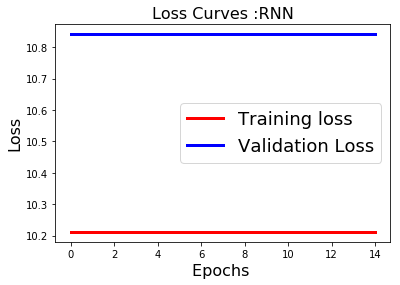

In [37]:
fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :RNN',fontsize=16)
fig1.savefig('loss_rnn.png')
plt.show()

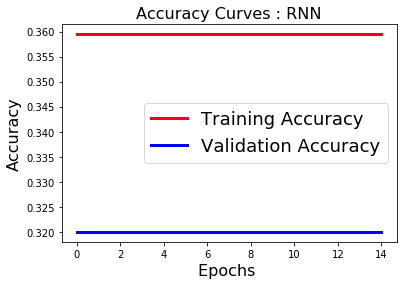

In [38]:
fig2=plt.figure()
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : RNN',fontsize=16)
fig2.savefig('accuracy_rnn.png')
# plt.show()

In [39]:
from PIL import Image
display(Image.open('rnn_model.png'))

ModuleNotFoundError: No module named 'PIL'